## Importing necessary libraries

In [1]:
import os
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import cv2
from sklearn.model_selection import train_test_split

## Downloading dataset

First, we download the `denoising-dirty-documents` dataset from https://www.kaggle.com/competitions/denoising-dirty-documents/data. Since it is hosted in Kaggle, we must ensure that Kaggle is installed in our Colab environment, and we keep `kaggle.json` in the `~/.kaggle/` directory.

In [3]:
! pip install -q kaggle # install kaggle in colab
!rm -r ~/.kaggle # remove any existing .kaggle directory
!mkdir ~/.kaggle # create a new .kaggle directory

rm: cannot remove '/root/.kaggle': No such file or directory


After creating the `~/.kaggle/` directory, we upload the `kaggle.json` file downloaded from the Kaggle user account.

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"morshedalam","key":"8b7d0712e2582fa65f1cdc89c53ace40"}'}

And move the `kaggle.json` file into the `~/.kaggle` directory.

In [5]:
!mv ./kaggle.json ~/.kaggle/ # move the kaggle.json file to the newly created directory
!chmod 600 ~/.kaggle/kaggle.json # change permnission
!ls -l ~/.kaggle/kaggle.json

-rw------- 1 root root 67 Apr 30 06:50 /root/.kaggle/kaggle.json


Now, we have everything in place to start downloading the dataset.

In [6]:
# download the compressed dataset
!kaggle competitions download -c denoising-dirty-documents

 98% 35.0M/35.7M [00:00<00:00, 86.6MB/s]
100% 35.7M/35.7M [00:00<00:00, 83.6MB/s]


## Unzipping dataset files

we plan to create a `data` directory before we start unzipping the dataset files. The following code shows the whole unzipping process. 

In [7]:
# create a 'data' directory inside "/content/"
!mkdir /content/data

# remove the zip file after unzipping the files in the 'data' directory
!unzip -q /content/denoising-dirty-documents.zip -d /content/data/ 
!rm -r /content/denoising-dirty-documents.zip 

# unzip individual data files from 'data' directory and remove zip files
!unzip -q /content/data/test.zip -d /content/data/denoising-dirty-documents/
!rm -r /content/data/test.zip

!unzip -q /content/data/train.zip -d /content/data/denoising-dirty-documents/
!rm -r /content/data/train.zip

!unzip -q /content/data/train_cleaned.zip -d /content/data/denoising-dirty-documents/
!rm -r /content/data/train_cleaned.zip

!unzip -q /content/data/sampleSubmission.csv.zip -d /content/data/denoising-dirty-documents/
!rm -r /content/data/sampleSubmission.csv.zip

## Data preprocessing

In this module, we check the dimensions of `train` images, convert all `train`, `test`, and `train_cleaned` images into a fixed shape. We also normalize all images, convert them into numpy arrays, and keep them prepared for the network model.

First, let's set specify the data directories.

In [5]:
# ROOT_DIR = '/content/'
ROOT_DIR = '../'
DATA_DIR = os.path.join(ROOT_DIR, 'data') 
RAW_DATA_DIR = os.path.join(DATA_DIR, 'denoising-dirty-documents')
TRAIN_DIR = os.path.join(RAW_DATA_DIR, 'train')
TEST_DIR = os.path.join(RAW_DATA_DIR, 'test')
TRAIN_CLEANED_DIR = os.path.join(RAW_DATA_DIR, 'train_cleaned')

We define the following two methods: `check_image_dimensions()` to find the minimum widths and heights of training images, and `process_image()` to convert, normalize, and reshape all images.

In [6]:
# method to get minimum widths and heights of images
def check_image_dimensions(image_dir):
    width, height = [], []

    for image_name in os.listdir(image_dir):
        # read the current image
        img = cv2.imread(os.path.join(image_dir, image_name))

        # get width and height of the current image
        height_, width_ = img.shape[0], img.shape[1]

        # add height and width into lists
        height.append(height_)
        width.append(width_)

    return min(width), min(height)


# method to process images
def process_image(img_path, new_height, new_width):
    # Open the image file
    image = cv2.imread(img_path)

    # convert the image intp a numpy array
    image = np.asarray(image, dtype="float32")

    # Resize image to the fixed new size
    image = cv2.resize(image, (new_width, new_height))

    # Normalize image to the range 0-255
    image = image / 255.0

    # reshape the dimension
    image = np.reshape(image, (new_height, new_width, 3))

    return image


Now, let's find out the minimum widths and heights of training images and use this dimension to process `train`, `test`, and `train_cleaned` images.

In [7]:
# get the minimum widths of heights of 'train' images
min_width, min_height = check_image_dimensions(TRAIN_DIR)
print(f'Minimum width: {min_width}, minimum height: {min_height}')

train_processed = []
test_processed = []
train_cleaned_processed = []

# process 'train' images by calling the process_image() method
for img in os.listdir(TRAIN_DIR):
    img_path = os.path.join(TRAIN_DIR, img)
    train_processed.append(process_image(img_path, min_height, min_width))

# process 'test' images by calling the process_image() method
for img in os.listdir(TEST_DIR):
    img_path = os.path.join(TEST_DIR, img)
    test_processed.append(process_image(img_path, min_height, min_width))

# process 'train' images by calling the process_image() method
for img in os.listdir(TRAIN_CLEANED_DIR):
    img_path = os.path.join(TRAIN_CLEANED_DIR, img)
    train_cleaned_processed.append(process_image(img_path, min_height, min_width))


Minimum width: 540, minimum height: 258


## Data splitting

We use the `train_test_split()` method from `sklearn.model_selection` module to split training datasets and determine `X_train`, `X_val`, `Y_train`, `Y_val`.

In [8]:
# convert list to numpy array
X_train = np.asarray(train_processed)
Y_train = np.asarray(train_cleaned_processed)
X_test = np.asarray(test_processed)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20)

## Defining network model

Now, it's time to define the network model that will act as a convolutional autoencoder to denoise noisy images.

The following `model()` method provides us the skeleton of the network model.

In [9]:
def model(width, height):
    # define the input layer with the fixed dimension we used for processing images
    input_layer = tf.keras.layers.Input(shape=(height, width, 3))

    # encoding
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # decoding
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    # define the output layer
    output_layer = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # create the model with the defines input and output layers
    model = tf.keras.models.Model(inputs=[input_layer], outputs=[output_layer])

    # compile the model with "adam" optimzer and "mse" loss
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

Now, let's generate a model that is compiled using `adam` optimizer and `MSE` loss. We define `MAE` as the evaution metrics here.

In [10]:
# generate the model by calling the model() method
cae_model = model(min_width, min_height)
cae_model.summary()

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 258, 540, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 258, 540, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 258, 540, 64)      18496     
                                                                 
 batch_normalization (BatchN  (None, 258, 540, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 270, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)         

## Model training

Before we start trainin the generated model, let's define a `EarlyStopping` callback fuction to monitor loss.

In [11]:
# callback method
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


Now, let's start training the model. We consider `200` epochs for the traning process and keep the `batch_size` 16.

In [12]:
# start training
history = cae_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=200, batch_size=16, callbacks=[callback])


Epoch 1/200


2023-04-30 01:58:10.380744: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 5s 511ms/step - loss: 0.2056 - mae: 0.3885 - val_loss: 0.2001 - val_mae: 0.4338
Epoch 2/200
8/8 [==============================] - 4s 480ms/step - loss: 0.1316 - mae: 0.2987 - val_loss: 0.1869 - val_mae: 0.4194
Epoch 3/200
8/8 [==============================] - 4s 471ms/step - loss: 0.1009 - mae: 0.2562 - val_loss: 0.1583 - val_mae: 0.3861
Epoch 4/200
8/8 [==============================] - 4s 467ms/step - loss: 0.0816 - mae: 0.2268 - val_loss: 0.1121 - val_mae: 0.3212
Epoch 5/200
8/8 [==============================] - 4s 476ms/step - loss: 0.0684 - mae: 0.2019 - val_loss: 0.0861 - val_mae: 0.2703
Epoch 6/200
8/8 [==============================] - 4s 465ms/step - loss: 0.0582 - mae: 0.1847 - val_loss: 0.0755 - val_mae: 0.2417
Epoch 7/200
8/8 [==============================] - 4s 470ms/step - loss: 0.0495 - mae: 0.1698 - val_loss: 0.0679 - val_mae: 0.2145
Epoch 8/200
8/8 [==============================] - 4s 444ms/step - loss: 0.0437 - mae: 0.1498 -

8/8 [==============================] - 3s 425ms/step - loss: 0.0036 - mae: 0.0304 - val_loss: 0.0158 - val_mae: 0.0561
Epoch 64/200
8/8 [==============================] - 3s 431ms/step - loss: 0.0036 - mae: 0.0303 - val_loss: 0.0135 - val_mae: 0.0516
Epoch 65/200
8/8 [==============================] - 3s 436ms/step - loss: 0.0039 - mae: 0.0311 - val_loss: 0.0117 - val_mae: 0.0495
Epoch 66/200
8/8 [==============================] - 3s 433ms/step - loss: 0.0037 - mae: 0.0303 - val_loss: 0.0153 - val_mae: 0.0577
Epoch 67/200
8/8 [==============================] - 3s 431ms/step - loss: 0.0036 - mae: 0.0299 - val_loss: 0.0134 - val_mae: 0.0525
Epoch 68/200
8/8 [==============================] - 3s 418ms/step - loss: 0.0035 - mae: 0.0297 - val_loss: 0.0115 - val_mae: 0.0480
Epoch 69/200
8/8 [==============================] - 3s 422ms/step - loss: 0.0037 - mae: 0.0299 - val_loss: 0.0114 - val_mae: 0.0490
Epoch 70/200
8/8 [==============================] - 3s 436ms/step - loss: 0.0035 - mae: 0

Epoch 125/200
8/8 [==============================] - 4s 514ms/step - loss: 0.0026 - mae: 0.0238 - val_loss: 0.0018 - val_mae: 0.0193
Epoch 126/200
8/8 [==============================] - 4s 449ms/step - loss: 0.0026 - mae: 0.0237 - val_loss: 0.0022 - val_mae: 0.0215
Epoch 127/200
8/8 [==============================] - 4s 439ms/step - loss: 0.0025 - mae: 0.0236 - val_loss: 0.0018 - val_mae: 0.0177
Epoch 128/200
8/8 [==============================] - 4s 442ms/step - loss: 0.0027 - mae: 0.0241 - val_loss: 0.0021 - val_mae: 0.0217
Epoch 129/200
8/8 [==============================] - 4s 444ms/step - loss: 0.0026 - mae: 0.0237 - val_loss: 0.0018 - val_mae: 0.0209
Epoch 130/200
8/8 [==============================] - 4s 463ms/step - loss: 0.0026 - mae: 0.0237 - val_loss: 0.0029 - val_mae: 0.0252
Epoch 131/200
8/8 [==============================] - 4s 482ms/step - loss: 0.0025 - mae: 0.0236 - val_loss: 0.0016 - val_mae: 0.0184
Epoch 132/200
8/8 [==============================] - 4s 444ms/step - 

8/8 [==============================] - 4s 447ms/step - loss: 0.0022 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0161
Epoch 187/200
8/8 [==============================] - 3s 439ms/step - loss: 0.0022 - mae: 0.0213 - val_loss: 0.0016 - val_mae: 0.0188
Epoch 188/200
8/8 [==============================] - 4s 444ms/step - loss: 0.0021 - mae: 0.0211 - val_loss: 0.0015 - val_mae: 0.0205
Epoch 189/200
8/8 [==============================] - 4s 448ms/step - loss: 0.0021 - mae: 0.0211 - val_loss: 0.0033 - val_mae: 0.0262
Epoch 190/200
8/8 [==============================] - 3s 433ms/step - loss: 0.0023 - mae: 0.0216 - val_loss: 0.0013 - val_mae: 0.0164
Epoch 191/200
8/8 [==============================] - 4s 439ms/step - loss: 0.0023 - mae: 0.0216 - val_loss: 0.0015 - val_mae: 0.0173
Epoch 192/200
8/8 [==============================] - 3s 430ms/step - loss: 0.0021 - mae: 0.0211 - val_loss: 0.0013 - val_mae: 0.0164
Epoch 193/200
8/8 [==============================] - 3s 433ms/step - loss: 0.0021 -

## Evaluation

First, let's see how how the traning loss and mean absolute error (MAE) decreases over epochs.

In [13]:
def evaluate_model(history):
    # Check how loss & mae went down
    epoch_loss = history.history['loss']
    epoch_val_loss = history.history['val_loss']
    epoch_mae = history.history['mae']
    epoch_val_mae = history.history['val_mae']

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
    plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
    plt.title('Evolution of loss on train & validation datasets over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
    plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
    plt.title('Evolution of MAE on train & validation datasets over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='best')

    plt.show()

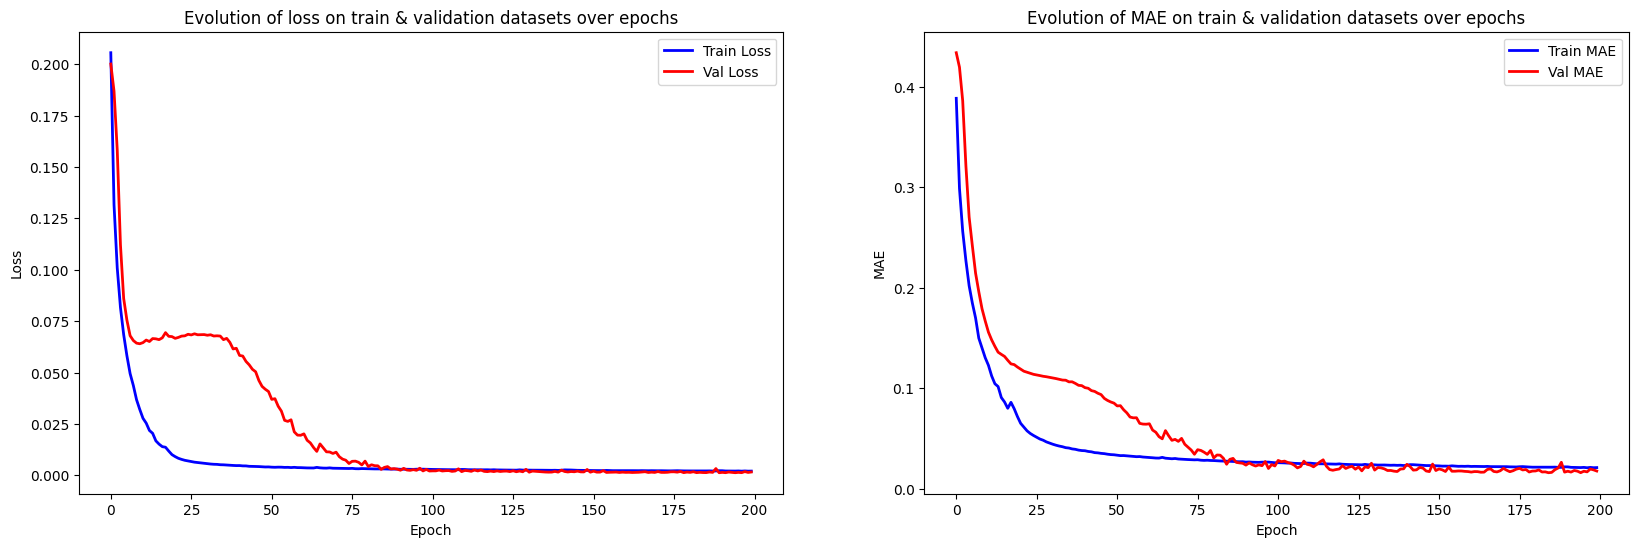

In [14]:
# Check how LOSS & MAE decreases over epochs
evaluate_model(history)

#### Now, it's time to check how much our model denoises test images `X_test`. 

Let's start with the `predict()` method.

In [15]:
# predict test images / denoise test images
Y_test = cae_model.predict(X_test, batch_size=16)

5/5 [==============================] - 1s 126ms/step


As our model generates `Y_test` from `X_test`, let's visually compare some noisy and denoised test images.

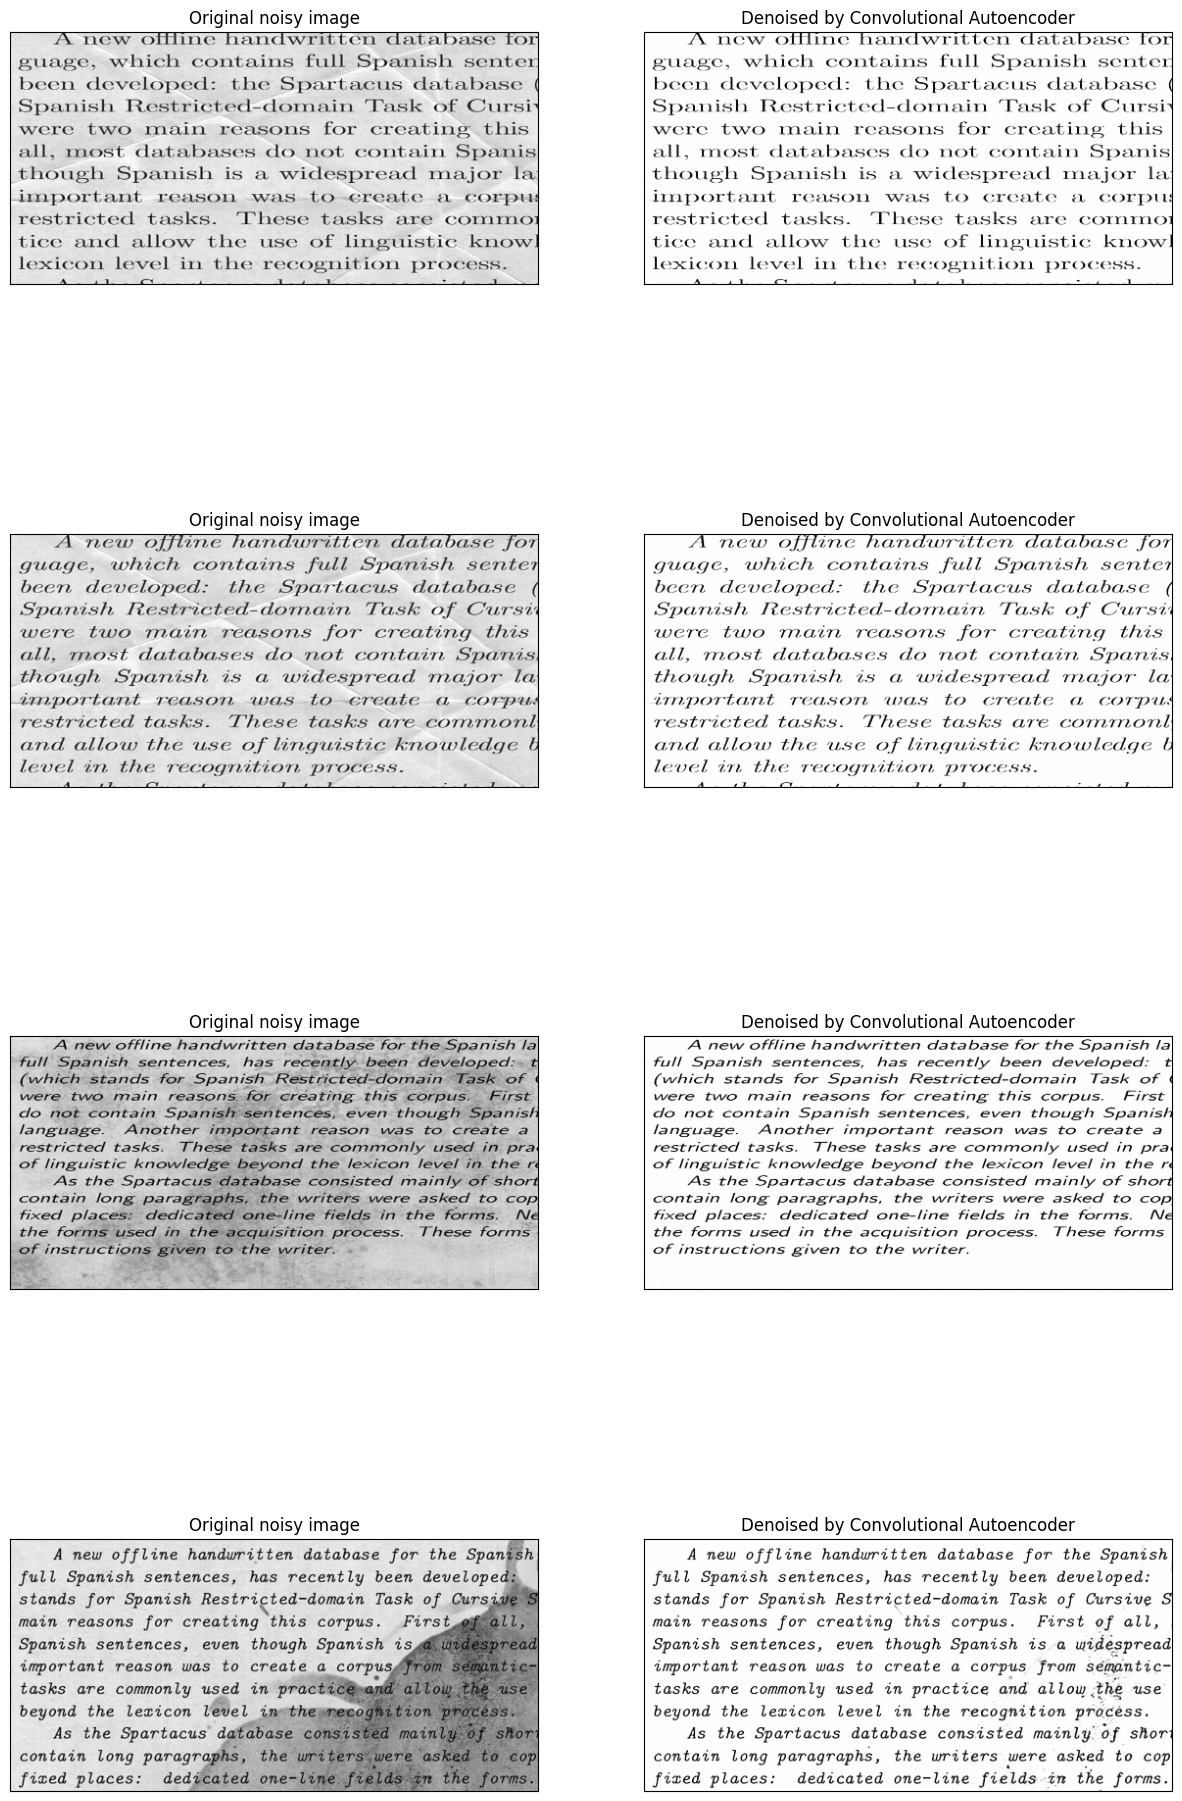

In [16]:
# Compare noisy and denoised test images
plt.figure(figsize=(15, 25))
for i in range(0, 8, 2):
    plt.subplot(4, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Original noisy image')

    plt.subplot(4, 2, i + 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i], cmap='gray')
    plt.title('Denoised by Convolutional Autoencoder')

plt.show()

## Model saving

After comparing noisy and denoised test images, it is clear that our autoencoder can denoise images with high accuracy. 

Now, let's save the trained model in a directory for furture usage.

In [17]:
os.mkdir('../saved_model2')
cae_model.save('../saved_model2/denoised_autoencoder_trained')

INFO:tensorflow:Assets written to: ../saved_model2/denoised_autoencoder_trained/assets


INFO:tensorflow:Assets written to: ../saved_model2/denoised_autoencoder_trained/assets
